# SGBM parameter configuration:
KITTI setup:
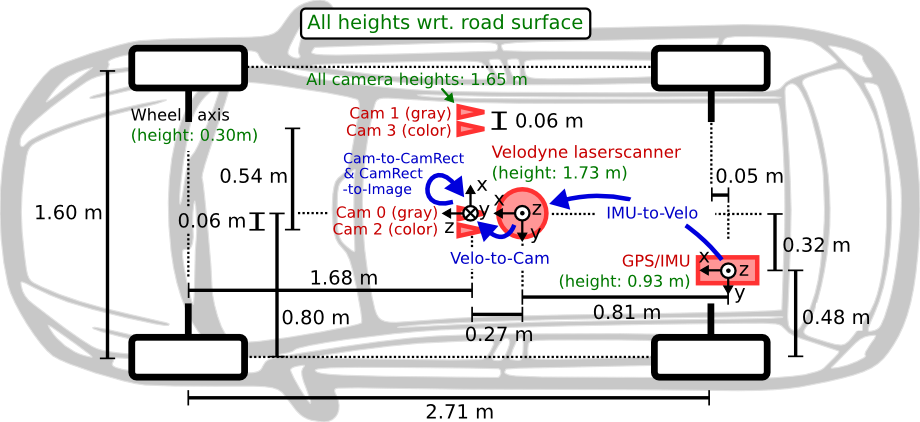

In [1]:
import numpy as np
import cv2
from pathlib import Path
import os
from matplotlib import pyplot as plt

## 1) camera parameters

### RGB CAMERA pair: cam 02(L) and 03(R)

In [2]:
# # check "calib_cam_to_cam.txt"
# # R, T relative to cam_0

# # cam_03
# right_camera_matrix = np.array([[9.037596e+02, 0.000000e+00, 6.957519e+02],
#                                 [0.000000e+00, 9.019653e+02, 2.242509e+02],
#                                 [0.000000e+00, 0.000000e+00, 1.000000e+00]])
# right_distortion = np.array(
#     [[-3.639558e-01, 1.788651e-01, 6.029694e-04, -3.922424e-04, -5.382460e-02]])

# # cam_02
# left_camera_matrix = np.array([[9.597910e+02, 0.000000e+00, 6.960217e+02],
#                                [0.000000e+00, 9.569251e+02, 2.241806e+02],
#                                [0.000000e+00, 0.000000e+00, 1.000000e+00]])
# left_distortion = np.array(
#     [[-3.691481e-01, 1.968681e-01, 1.353473e-03, 5.677587e-04, -6.770705e-02]])

# # calc SE in MATLAB
# R = np.matrix([
#     [0.9996, 0.0223, -0.0198],
#     [-0.0222, 0.9998, 0.0017],
#     [0.0198, -0.0013, 0.9998],
# ])

# T = np.array([-0.5327, 0.0080, -0.0054])

### GRAY CAMERA pair: cam 00(L) and 01(R)

In [3]:
# -> ACTUALLY USED FOR SGBM

# check "calib_cam_to_cam.txt"
# R, T relative to cam_0

# cam_01
right_camera_matrix = np.array([[9.895267e+02, 0.000000e+00, 7.020000e+02],
                                [0.000000e+00, 9.878386e+02, 2.455590e+02],
                                [0.000000e+00, 0.000000e+00, 1.000000e+00]])
right_distortion = np.array(
    [[-3.644661e-01, 1.790019e-01, 1.148107e-03, -6.298563e-04, -5.314062e-02]])

# cam_00
left_camera_matrix = np.array([[9.842439e+02, 0.000000e+00, 6.900000e+02],
                               [0.000000e+00, 9.808141e+02, 2.331966e+02],
                               [0.000000e+00, 0.000000e+00, 1.000000e+00]])
left_distortion = np.array(
    [[-3.728755e-01, 2.037299e-01, 2.219027e-03, 1.383707e-03, -7.233722e-02]])

# calc SE in MATLAB
R = np.matrix([
    [0.9994, 0.0186, -0.0308],
    [-0.0189, 0.9998, -0.0084],
    [0.0307, 0.0090, 0.9995],
])

T = np.array([-0.5370, 0.0048, -0.0125])

### Stereo rectification

In [4]:
size = (1242, 375)  # 图像尺寸  the rectified image size
# size = (1382, 512)  # the native image size, see https://github.com/yanii/kitti-pcl/blob/master/KITTI_README.TXT

# 进行立体更正
R1, R2, P1, P2, Q, validPixROI1, validPixROI2 = cv2.stereoRectify(left_camera_matrix, left_distortion,
                                                                  right_camera_matrix, right_distortion, size, R,
                                                                  T)
# 计算更正map
left_map1, left_map2 = cv2.initUndistortRectifyMap(
    left_camera_matrix, left_distortion, R1, P1, size, cv2.CV_16SC2)
right_map1, right_map2 = cv2.initUndistortRectifyMap(
    right_camera_matrix, right_distortion, R2, P2, size, cv2.CV_16SC2)


## 2) Read Image

In [5]:
def read_imgraw(path, frame, image_chn, color=False):
    img_filename = '%010d.png' % frame
    img_path = os.path.join(path, image_chn, 'data')

    cvimg = cv2.imread(os.path.join(img_path, img_filename))
    if color:
        cvimg = cv2.cvtColor(cvimg, cv2.COLOR_BGR2RGB)
    
    return cvimg

In [6]:
def show_image(img1, img2):
    _, axarr = plt.subplots(1,2, figsize=(15,15))
    axarr[0].imshow(img_L0)
    axarr[1].imshow(img_R0)

In [7]:
ROOT = "/home/jun/ros_kitti"
DATAID = '0005'
DATA_PATH = ROOT+'/rawdata/2011_09_26/2011_09_26_drive_'+DATAID+'_sync/'

IMG_CHN = {'l_gray': 'image_00',
           'r_gray': 'image_01',
           'l_RGB': 'image_02',
           'r_RGB': 'image_03'}

In [8]:
frame = 5
img_L = read_imgraw(DATA_PATH, frame, IMG_CHN['l_RGB'], color=True)
img_R = read_imgraw(DATA_PATH, frame, IMG_CHN['l_RGB'], color=True)
img_L0 = read_imgraw(DATA_PATH, frame, IMG_CHN['l_gray'])
img_R0 = read_imgraw(DATA_PATH, frame, IMG_CHN['r_gray'])


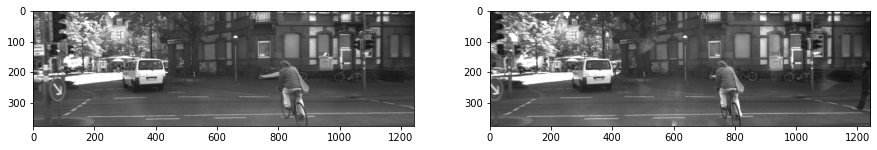

In [9]:
show_image(img_L0, img_R0)

## 3) Trying SGBM params
Check the corresponding OpenCV doc [here](https://docs.opencv.org/3.4/d9/d0c/group__calib3d.html#ga617b1685d4059c6040827800e72ad2b6)  

In [10]:
def distance_calc(frame1, frame2, stereo, rectified=True, WLSfilter=False):
    # ensure rectified
    if not rectified:
        img1_rectified = cv2.remap(
            frame1, left_map1, left_map2, cv2.INTER_LINEAR)
        img2_rectified = cv2.remap(
            frame2, right_map1, right_map2, cv2.INTER_LINEAR)
    else:
        img1_rectified = frame1
        img2_rectified = frame2

    # Ensure image in grey scale
    if len(img1_rectified.shape) == 3:
        imgL = cv2.cvtColor(img1_rectified, cv2.COLOR_BGR2GRAY)
    else:
        imgL = img1_rectified
    if len(img2_rectified.shape) == 3:
        imgR = cv2.cvtColor(img2_rectified, cv2.COLOR_BGR2GRAY)
    else:
        imgR = img2_rectified

    # Calculate disparity
    if not WLSfilter:
        # raw SGBM
        disp = stereo.compute(imgL, imgR).astype(np.float32) / 16.0
    else:
        # SGBM + WLS filter
        disp = disp_filter(imgL, imgR)

#     threeD = cv2.reprojectImageTo3D(disp, Q)
#     disp = cv2.cvtColor(disp, cv2.COLOR_BGR2RGB)
    return disp

### 01

In [11]:
STEREO = cv2.StereoSGBM_create(
    minDisparity=5,
    numDisparities=4*16,
    blockSize=3,
    uniquenessRatio=10,
    speckleRange=20,  # 视差变化阈值
    speckleWindowSize=10,
    disp12MaxDiff=1,  # 左右视差图的最大容许差异
    P1=8*3*4*4,  # 惩罚系数
    P2=32*3*4*4,
    preFilterCap=-1,
    mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
)

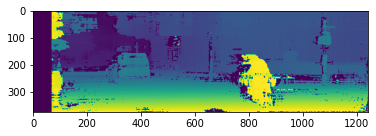

In [12]:
plt.imshow(distance_calc(img_L0, img_R0, STEREO))

In [13]:
STEREO = cv2.StereoSGBM_create(
    minDisparity=5,
    numDisparities=4*16,
    blockSize=3,
    uniquenessRatio=10,
    speckleRange=100,  # 视差变化阈值
    speckleWindowSize=100,
    disp12MaxDiff=-1,  # 左右视差图的最大容许差异
    P1=8*3*3*3,  # 惩罚系数
    P2=32*3*3*3,
    preFilterCap=1,
    mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
)

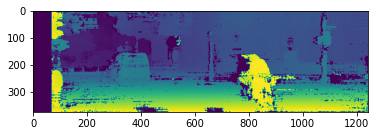

In [14]:
plt.imshow(distance_calc(img_L0, img_R0, STEREO))

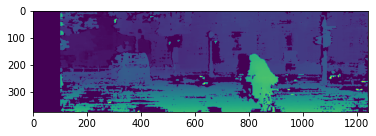

In [15]:
STEREO = cv2.StereoSGBM_create(
    minDisparity=5,
    numDisparities=6*16,
    blockSize=5,
    P1=8 * 3 * 10,
    P2=32 * 3 * 10,
    disp12MaxDiff=1,
    uniquenessRatio=15,
    speckleWindowSize=31,
    speckleRange=2,
    preFilterCap=3,
    mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
)
plt.imshow(distance_calc(img_L0, img_R0, STEREO))

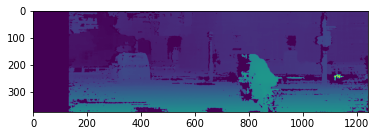

In [16]:
STEREO = cv2.StereoSGBM_create(
    minDisparity=5,
    numDisparities=8*16,
    blockSize=5,
    uniquenessRatio=10,
    speckleRange=10,  # 视差变化阈值
    speckleWindowSize=100,
    disp12MaxDiff=1,  # 左右视差图的最大容许差异
    P1=8*3*5*5,  # 惩罚系数
    P2=32*3*5*5,
    preFilterCap=15,
    mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
)
plt.imshow(distance_calc(img_L0, img_R0, STEREO))

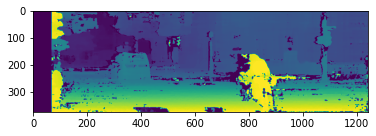

In [17]:
STEREO = cv2.StereoSGBM_create(
    minDisparity=5,
    numDisparities=4*16,
    blockSize=7,
    uniquenessRatio=10,
    speckleRange=20,  # 视差变化阈值
    speckleWindowSize=20,
    disp12MaxDiff=1,  # 左右视差图的最大容许差异
    P1=8*3*6*6,  # 惩罚系数
    P2=32*3*6*6,
    preFilterCap=-1,
    mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
)
plt.imshow(distance_calc(img_L0, img_R0, STEREO))

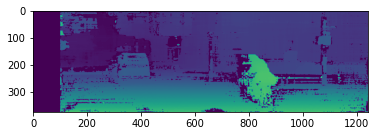

In [18]:
STEREO = cv2.StereoSGBM_create(
    minDisparity=5,
    numDisparities=6*16,
    blockSize=3,
    uniquenessRatio=15,
    speckleRange=15,  # 视差变化阈值
    speckleWindowSize=10,
    disp12MaxDiff=1,  # 左右视差图的最大容许差异
    P1=8*3*4*4,  # 惩罚系数
    P2=32*3*4*4,
    preFilterCap=-1,
    mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
)
plt.imshow(distance_calc(img_L0, img_R0, STEREO))